In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy.stats import vonmises
from scipy.stats import vonmises
from scipy.stats import pearsonr
from scipy.stats import sem

In [3]:
%matplotlib inline

In [4]:
np.random.seed(0)

# Helper functions

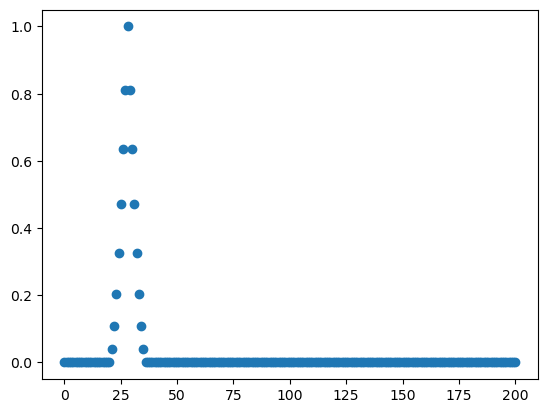

array([[28]])

In [5]:
from scipy.special import i0  
def make_bump(size, center, vm_params=(10., 0.), squish=5):
    assert(center < size)
    if vm_params is not None:
        kappa, scale = vm_params
        x = np.linspace(-np.pi, np.pi, size)
        halfbump = np.exp(kappa*np.cos(x-scale)/(2*np.pi*i0(kappa)))
        halfbump = halfbump[:halfbump.size//2][::-1]
        halfbump = [halfbump[0]] + halfbump[55:]
        halfbump = halfbump[::squish]
        halfbump = halfbump-halfbump.min()
        halfbump = halfbump/halfbump.max()
        bump = np.zeros(size)
        bump[:halfbump.size] = halfbump
        bump[-halfbump.size+1:] = halfbump[1:][::-1]
        offset = 0.
        bump = bump - offset
        bump[bump < 0] = 0
        bump /= bump.max()
        bump = np.roll(bump, center)
    else:
        xs = np.linspace(np.pi/2, -3*np.pi/2, size, endpoint=False)
        bump = np.sin(xs)
        bump = np.roll(bump, center)
        bump[bump < 0] = 0
    return bump

plt.figure()
plt.scatter(np.arange(201), make_bump(201, 28))
plt.show()
test_bump = make_bump(201, 28)
np.argwhere(test_bump==test_bump.max())

In [6]:
def relu(X):
    return np.maximum(0, X)

In [7]:
from scipy.special import softmax

# Network initialization

In [8]:
n_spatial = 201
n_barcode = 601 #501 # Must be >= n_spatial
n_cache = 1 # Three types

In [9]:
N = n_spatial + n_barcode + n_cache

In [10]:
J = np.zeros((N, N)) # (s,b,c) ordering
s_start = 0
s_end = n_spatial
b_start = s_end
b_end = b_start + n_barcode
c_start = b_end
c_end = -1
SEED = c_start

In [11]:
seed_locs = [int(n_spatial*0.3), int(n_spatial*0.5)]

In [12]:
# W_sb = W_bs.T as sparse connections
space_to_bar = {}

# for i in range(n_spatial): # space to barcode
#     bs = np.random.binomial(n=1, p=p, size=n_barcode)
#     bs = np.argwhere(bs)[:,0]
#     J[b_start+bs, s_start+i] = 1
counts = np.zeros(n_barcode)
for i in range(n_spatial):
#     chosen_bs = i
#     J_val = 1.
    
#     n_bs = 2
#     J_val = (1./n_bs)*1.
#     chosen_bs = np.random.choice(n_barcode, size=n_bs, replace=False)
#     counts[chosen_bs] += 1
#     if i in seed_locs:
#         print(chosen_bs)
        
    p = 0.001
    chosen_bs = np.random.binomial(n=1, p=p, size=n_barcode)
    chosen_bs = np.argwhere(chosen_bs)[:,0]
    n_bs = chosen_bs.size
    if n_bs == 0: continue
    J_val = (1./n_bs)*1.
    counts[chosen_bs] += 1
    if i in seed_locs:
        print(chosen_bs)
    J[b_start + chosen_bs, s_start+i] = J_val
    space_to_bar[s_start+i] = chosen_bs
    
J[s_start:s_end, b_start:b_end] = J[b_start:b_end, s_start:s_end].T

# for _s in range(s_start, s_end):
#     J[b_start:b_end, _s] /= np.sum(J[b_start:b_end, _s])

[96]
[ 94 184]


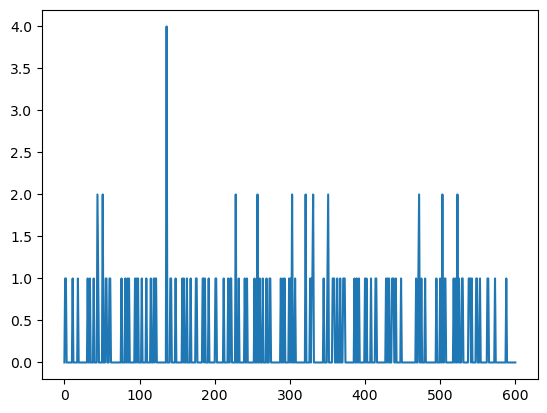

In [13]:
plt.figure()
plt.plot(counts)
plt.show()

# Task-defined connections

60
[[96]]


<Figure size 640x480 with 0 Axes>

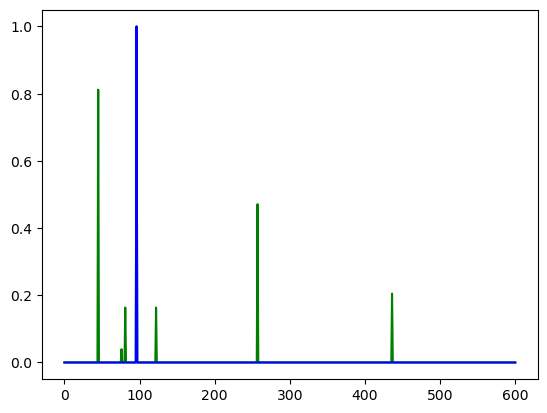

100
[[500]]


<Figure size 640x480 with 0 Axes>

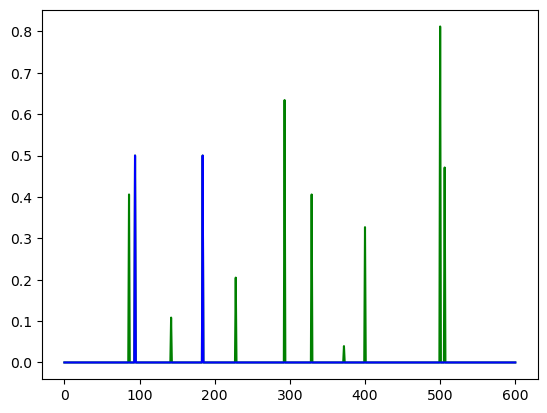

In [14]:
# Many-to-one connections from barcode to cache type (W_bc)
for l in seed_locs:
    bump = make_bump(n_spatial, l)
    b_activations = J[b_start:b_end, s_start:s_end]@bump
    print(np.argmax(bump))
    b = np.argwhere(b_activations == b_activations.max())
    print(b)
    J[b_start + b, SEED] = 1/b.size
    J[SEED, b_start + b] = 1/b.size
    plt.figure()
    plt.figure()
    plt.plot(b_activations, color='green')
    plt.plot(J[b_start:b_end, l], color='blue')
    plt.show()

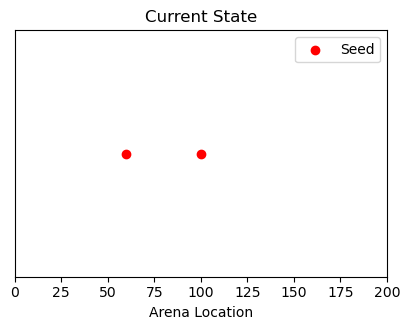

In [15]:
plt.figure(figsize=(4.8, 6.4*0.5))
plt.scatter(
    seed_locs, [1]*len(seed_locs), color='red',
    label='Seed')
plt.legend()
plt.xlim(0, n_spatial-1)
plt.ylim(0, 2)
plt.yticks([])
plt.xlabel('Arena Location')
plt.title('Current State')
plt.show()

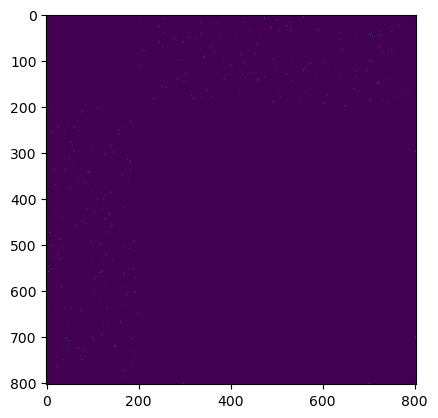

In [16]:
plt.figure()
plt.imshow(J)
plt.show()

# Dynamics Function

In [17]:
def get_activity(
    T, i, softmax_temp=3):
    
    x = x_prev = np.zeros(N)
    x_prev = i
    activities = []
    for t in range(T):
        x = J@(0.95*x_prev) + i
        x[b_start:b_end] = softmax(x[b_start:b_end]*softmax_temp)
        x[b_start:b_end] -= 1.1/n_barcode
        x = relu(x)
        x_prev = x
        activities.append(np.copy(x))
    return activities

# Capacity Plots

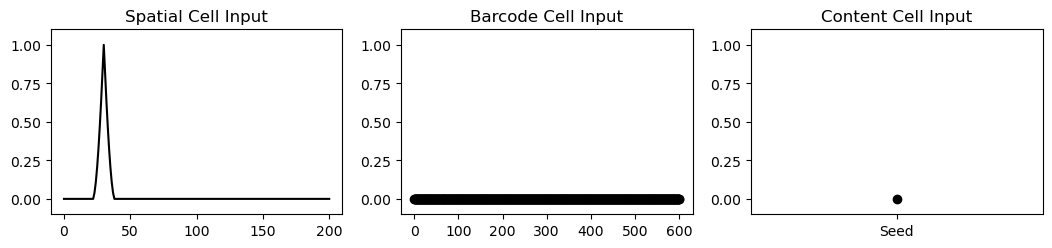

In [18]:
i = np.zeros(N)
i[s_start:s_end] = make_bump(n_spatial, 30)
i[b_start:b_end] = 0.

fig, axs = plt.subplots(1, 3, figsize=(6.4*2, 4.8*0.5))
axs[0].plot(i[s_start:s_end], color='k')
axs[1].scatter(np.arange(n_barcode), i[b_start:b_end], color='k')
axs[2].scatter(np.arange(n_cache), i[c_start:], color='k')
axs[0].set_title('Spatial Cell Input')
axs[1].set_title('Barcode Cell Input')
axs[2].set_title('Content Cell Input')
axs[2].set_xticks([0], ['Seed'])
for ax in axs:
    ax.set_ylim(-.1, 1.1)
plt.show()

In [19]:
seed_locs

[60, 100]

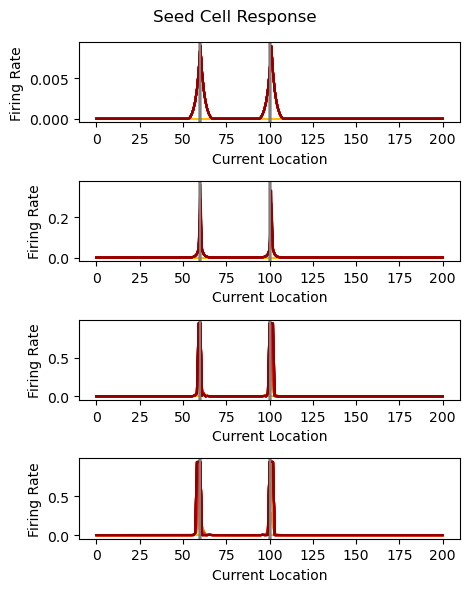

In [20]:
T = 20
noise_std = 0.
temps = [2,4,5,6]
bump_strength = 1.
fig, axs = plt.subplots(4, 1, figsize=(6.4*0.75, 4.8*1.25))

for temp_idx, temp in enumerate(temps):
    T_lines = [[] for _ in range(T)]
    for loc in np.arange(n_spatial):
        i = np.zeros(N)
        i[s_start:s_end] = make_bump(n_spatial, loc)*bump_strength
        activities = get_activity(T, i, softmax_temp=temp)
        for t in range(T):
            x = activities[t]
            T_lines[t].append(x[SEED])
    color = plt.cm.hot_r(np.linspace(0.35, 0.8, T))
    for t in range(T):
        line = T_lines[t]
        axs[temp_idx].plot(line, label=t, color=color[t])
        axs[temp_idx].set_ylabel('Firing Rate')
        axs[temp_idx].set_xlabel('Current Location')
        axs[temp_idx].axvline(seed_locs[0], color='gray')
        axs[temp_idx].axvline(seed_locs[1], color='gray')
plt.suptitle('Seed Cell Response')
plt.tight_layout()
plt.show()

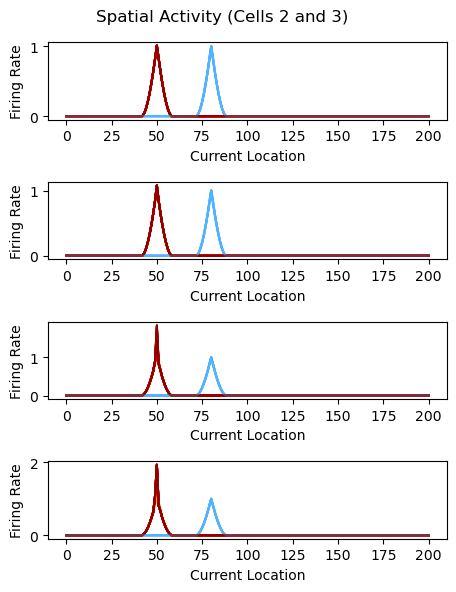

In [21]:
fig, axs = plt.subplots(4, 1, figsize=(6.4*0.75, 4.8*1.25))

for temp_idx, temp in enumerate(temps):
    T_lines = [[] for _ in range(T)]
    T_lines3 = [[] for _ in range(T)]
    for loc in np.arange(n_spatial):
        i = np.zeros(N)
        i[s_start:s_end] = make_bump(n_spatial, loc)*bump_strength
        noisy_i = i + np.random.normal(0, 0., size=i.size)
        activities = get_activity(T, noisy_i, softmax_temp=temp)
        for t in range(T):
            x = activities[t]
            T_lines[t].append(x[s_start+50])
            T_lines3[t].append(x[s_start+80])
    color = plt.cm.hot_r(np.linspace(0.35, 0.8, T))
    color3 = plt.cm.cool_r(np.linspace(0.35, 0.8, T))
    for t in range(T):
        line = T_lines[t]
        axs[temp_idx].plot(line, label=t, color=color[t])
        line3 = T_lines3[t]
        axs[temp_idx].plot(line3, label=t, color=color3[t], alpha=0.25)
        #axs[temp_idx].set_yticks([])
        axs[temp_idx].set_ylabel('Firing Rate')
        axs[temp_idx].set_xlabel('Current Location')
plt.suptitle('Spatial Activity (Cells 2 and 3)')
plt.tight_layout()
plt.show()

# Memory Plots

### Inputs

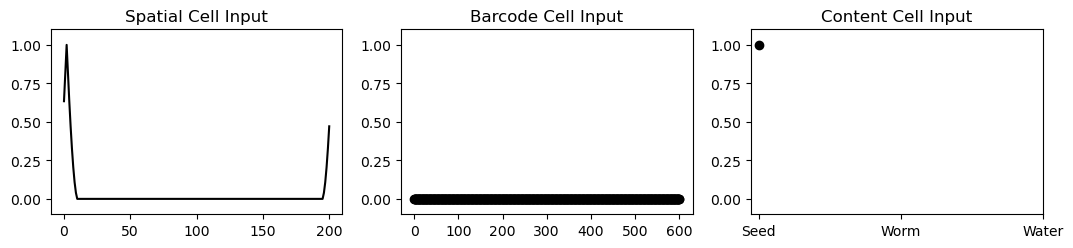

In [25]:
seed_strength = 1

# Given current location and seed type, what's the spatial gradient?
i = np.zeros(N)
i[s_start:s_end] = make_bump(n_spatial, 2)*bump_strength
i[SEED] = seed_strength
fig, axs = plt.subplots(1, 3, figsize=(6.4*2, 4.8*0.5))
axs[0].plot(i[s_start:s_end], color='k')
axs[1].scatter(np.arange(n_barcode), i[b_start:b_end], color='k')
axs[2].scatter(np.arange(n_cache), i[c_start:], color='k')
axs[0].set_title('Spatial Cell Input')
axs[1].set_title('Barcode Cell Input')
axs[2].set_title('Content Cell Input')
axs[2].set_xticks([0,1,2], ['Seed', 'Worm', 'Water'])
for ax in axs:
    ax.set_ylim(-.1, 1.1)
plt.show()

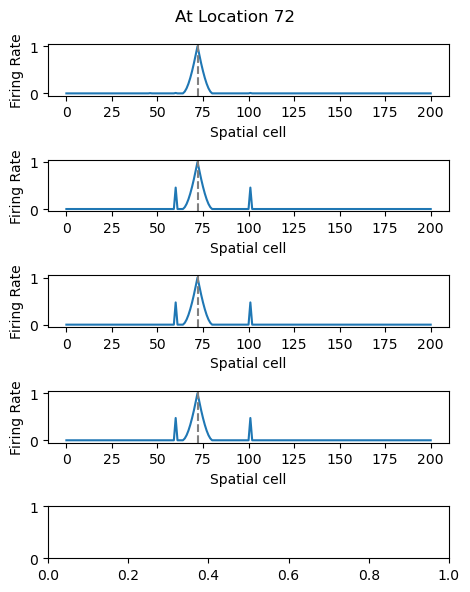

In [26]:
plot_t = T-1
iters = 1
fig, axs = plt.subplots(5, 1, figsize=(6.4*0.75, 4.8*1.25))
test_loc = seed_locs[0] + (seed_locs[1]-seed_locs[0])*0.3
test_loc = int(test_loc)

for temp_idx, temp in enumerate(temps):
    X = []
    for _ in range(iters):
        i = np.zeros(N)
        i[s_start:s_end] = make_bump(n_spatial, test_loc)*bump_strength
        i[SEED] = seed_strength
        activities = get_activity(T, i, softmax_temp=temp)
        x = activities[plot_t]
        X.append(x[s_start:s_end])
    X = np.array(X).T
    means = np.mean(X, axis=1)
    sems = sem(X, axis=1)
    axs[temp_idx].plot(means)
    #axs[temp_idx].bar(np.arange(n_spatial), means, xerr=sems)
    axs[temp_idx].set_xlabel('Spatial cell')
    axs[temp_idx].set_ylabel('Firing Rate')
    axs[temp_idx].axvline(test_loc, color='gray', linestyle='--')
    #axs[temp_idx].set_yticks([])
plt.suptitle(f'At Location {test_loc}')
plt.tight_layout()
plt.show()

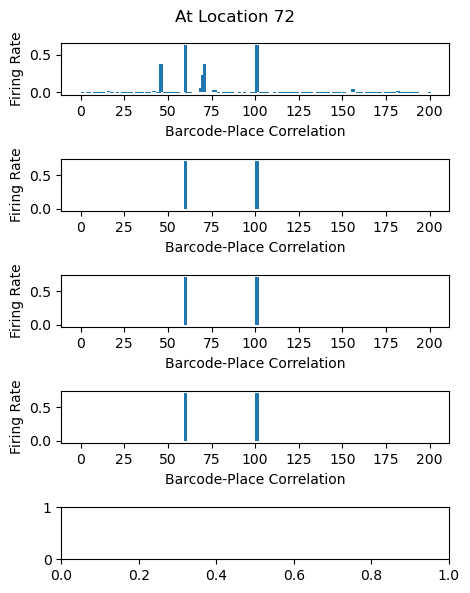

In [27]:
plot_t = T-1
iters = 1
noise_std = 0.
fig, axs = plt.subplots(5, 1, figsize=(6.4*0.75, 4.8*1.25))
for temp_idx, temp in enumerate(temps):
    X = []
    for _ in range(iters):
        i = np.zeros(N)
        i[s_start:s_end] = make_bump(n_spatial, test_loc)*bump_strength
        i[SEED] = seed_strength
        activities = get_activity(T, i, softmax_temp=temp)
        x = activities[plot_t]
        corrs = []
        for l in np.arange(n_spatial):
            barcode = np.zeros(n_barcode)
            if l not in space_to_bar.keys():
                corr = 0
            else:
                barcode[space_to_bar[l]] = 1
                corr = pearsonr(x[b_start:b_end], barcode)[0] 
                #corr = np.dot(x[b_start:b_end], barcode)
            corrs.append(corr)
        X.append(corrs)
    X = np.array(X).T
    means = np.mean(X, axis=1)
    sems = sem(X, axis=1)
    #axs[temp_idx].scatter(np.arange(n_spatial), means)
    axs[temp_idx].bar(np.arange(n_spatial), means, width=2)
    axs[temp_idx].set_xlabel('Barcode-Place Correlation')
    axs[temp_idx].set_ylabel('Firing Rate')
#     axs[temp_idx].set_yticks([])
plt.suptitle(f'At Location {test_loc}')
plt.tight_layout()
plt.show()